In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
def kronecker(i,j) -> int:
    if i == j:
        return 1
    else:
        return 0

## Passive Transport - thermodynamics
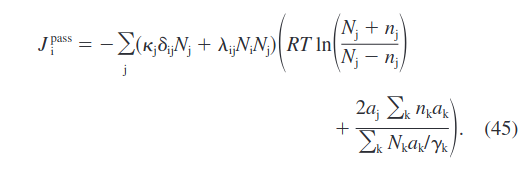

In [120]:
lipids = ['Chol','PC','PE','PS','SM']

N_lipids = np.array([3.5, 1.24, 1.12, 0.55, 1.04])
lip_inside = np.array([.01,.01,.80,.90,.01]) * N_lipids
lip_outside = np.array([.99,.99,.20,.10,.99]) * N_lipids
area_species = 0.6 # lipid area
gemma = 0.25 # compression force constants
R = 8.31446261815324*1e-3 # universelle gas constant
Temp =  310.15 # 37°C ~ human body temperatur
# Phenomenological parameters
kappa = np.array([1, 1/1000, 1/600, 1/600, 1/4000])
lambda_pheno = 1/670
k = len(lipids)

a_area_array = np.ones(k) * area_species
y_gemma_curveture_array = np.ones(k) * gemma
n_species_diff_array = np.ones(k) * (lip_inside - lip_outside)
N_sum_species_array = np.ones(k) * (lip_inside + lip_outside)

kappa_N_array = kappa * N_lipids
N_times_N_matrix = np.outer(N_lipids,N_lipids) * lambda_pheno
chemical_array = R * Temp * np.log(np.ones(k) * lip_inside / lip_outside)
mechanic_value = np.sum(n_species_diff_array * a_area_array)/np.sum(N_lipids * a_area_array/y_gemma_curveture_array)
mechanic_array = 2 * a_area_array * np.sum(n_species_diff_array * a_area_array)\
                    /np.sum(N_lipids * a_area_array/y_gemma_curveture_array)

In [127]:
passive_fluxes = np.zeros(k)
for i, lipid in enumerate(lipids):
    for j in range(k):
        passive_fluxes[i] += -((kronecker(i,j) * kappa_N_array[j]+ N_times_N_matrix[i,j])\
                                * (chemical_array[j] + mechanic_array[j]))
    
passive_fluxes

array([21.6406864 ,  0.07546741,  0.06837762,  0.02510744,  0.05851516])

In [148]:
np.sum(passive_mat, axis=1)

array([-21.6406864 ,  -0.07546741,  -0.06837762,  -0.02510744,
        -0.05851516])

## Active Flux
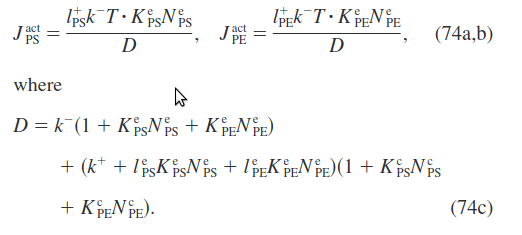

In [105]:
l_PS = 2.0 * 1e4
l_PE = l_PS
k_plus = 4.0 * 1e4
k_minus = k_plus
cyto_K_PS = (1.0 * 1e3)**(-1)
cyto_K_PE = cyto_K_PS
exo_K_PS = 0.5**(-1)
exo_K_PE = 5.0**(-1)
Transporter = 5.5*1e-6
index_PS = 3
index_PE = 2

d_part_1 = k_minus*(1 + exo_K_PS * lip_outside[index_PS] + exo_K_PE * lip_outside[index_PE])
d_part_2_1 = (k_plus + l_PS * exo_K_PS * lip_outside[index_PS] + l_PE * exo_K_PE * lip_outside[index_PE])
d_part_2_2 = (1 + cyto_K_PS * lip_inside[index_PS] + cyto_K_PE * lip_inside[index_PE])

d = d_part_1 + d_part_2_1 * d_part_2_2
# Fluxes
j_active_PS = l_PS * k_minus * Transporter * exo_K_PS * lip_outside[index_PS] / d
j_active_PE = l_PE * k_minus * Transporter * exo_K_PE * lip_outside[index_PE] / d
print(j_active_PE)
print(j_active_PS)

0.008096530864921143
0.004969968722886862


In [6]:
1/670


0.0014925373134328358

In [284]:
N_lipids = np.array([3.5, 1.24, 1.12, 0.55, 1.04])
lipids = ['Chol','PC','PE','PS','SM']

def dxdy(t, substrates, lam, off=100000, gamma=[0.25]*5, area_species=[0.6]*5):

    lip_inside = substrates[:5]
    lip_outside = substrates[5:]
    
    index_PS = 3
    index_PE = 2
    
    N_lipids = lip_inside + lip_outside
    
    # Phenomenological parameters
    R = 8.31446261815324*1e-3 # in J/(K*mmol) universal gas constant
    Temp =  310.15 # 37°C ~ human body temperatur
    gemma = 0.25#gamma #J*(m-2) (Question:*1e18 for m2 => nm^2 conversion?) compression force constants
    area_species = 0.6#area_species
    kappa = np.array([1, 1/1000, 1/600, 1/600, 1/4000]) / (4*R*Temp)
    lambda_pheno = lam / (4*R*Temp*np.sum(N_lipids))
    k = len(N_lipids)
    
    # active transport parameter
    l_PS = 2.0 * 1e4#5
    l_PE = l_PS
    k_plus = 4.0 * 1e4
    k_minus = k_plus
    cyto_K_PS = (1.0 * 1e3)**(-1)
    cyto_K_PE = cyto_K_PS
    exo_K_PS = 0.5**(-1)
    exo_K_PE = 5.0**(-1)
    Transporter = 5.5*1e-6
    
    switch = 1
    # Event
    if t > off:
        switch = 0
        
    # passive Transport
    a_area_array = np.ones(k) * area_species
    y_gemma_compression_array = np.ones(k) * gemma
    
    n_species_diff_array = lip_inside - lip_outside
    kappa_N_array = kappa * N_lipids
    lambda_N_N_matrix = lambda_pheno * np.outer(N_lipids,N_lipids)
    
    # driving Forces
    chemical_array = R * Temp * np.log(lip_inside / lip_outside)
    mechanic_array = 2 * a_area_array * np.sum(n_species_diff_array * a_area_array)\
                    /np.sum(N_lipids * a_area_array/y_gemma_compression_array)

    # passiv Fluxes calculation 
    mechanic = (np.diag(np.full(k,1))* kappa_N_array +  lambda_N_N_matrix) * (mechanic_array)
    chemic = (np.diag(np.full(k,1))* kappa_N_array +  lambda_N_N_matrix) * (chemical_array)
    
    passive_mat = chemic + mechanic *1e4 #TODO why the *1000 needed? 
    #passive_mat = (np.diag(np.full(k,1))* kappa_N_array + N_times_N_matrix) * (chemical_array + mechanic_array)
    passive_fluxes = passive_mat.sum(axis=1)*(-1)#(-5e-2)
    #print(passive_mat-(mechanic+chemic))
    chemical_array = chemic.sum(axis=1)
    mechanic_array = mechanic.sum(axis=1)
    # active transport
    d_part_1 = k_minus*(1 + exo_K_PS * lip_outside[index_PS] + exo_K_PE * lip_outside[index_PE])
    d_part_2_1 = (k_plus + l_PS * exo_K_PS * lip_outside[index_PS] + l_PE * exo_K_PE * lip_outside[index_PE])
    d_part_2_2 = (1 + cyto_K_PS * lip_inside[index_PS] + cyto_K_PE * lip_inside[index_PE])

    d = d_part_1 + d_part_2_1 * d_part_2_2
    # active transport Flux
    j_active_PS = l_PS * k_minus * Transporter * exo_K_PS * lip_outside[index_PS] / d
    j_active_PE = l_PE * k_minus * Transporter * exo_K_PE * lip_outside[index_PE] / d
    
    dchol_dt = passive_fluxes[0]
    dPC_dt = passive_fluxes[1]
    dPE_dt = switch * j_active_PE + passive_fluxes[index_PE]
    dPS_dt = switch * j_active_PS + passive_fluxes[index_PS]
    dSM_dt = passive_fluxes[4]
    
    
    #print(chemical_array[:1])
    #print(mechanic_array[:1])
    #print(passive_fluxes[:])
    #print(np.array([dchol_dt,dPC_dt,dPE_dt,dPS_dt,dSM_dt]))
    #print('--------')
    
    return np.array([dchol_dt,dPC_dt,dPE_dt,dPS_dt,dSM_dt,-dchol_dt,-dPC_dt,-dPE_dt,-dPS_dt,-dSM_dt])


In [453]:
lipids = ['Chol','PC','PE','PS','SM']

N_lipids = np.array([3.5, 1.24, 1.12, 0.55, 1.04])
lip_inside = np.array([.5,.5,.5,.5,.5]) * N_lipids
lip_outside = np.array([.5,.5,.5,.5,.5]) * N_lipids

y0 = np.append(lip_inside,lip_outside)
t_max = 20000
t = (0, t_max)
t_val = np.arange(0,t_max,1)
sol = solve_ivp(dxdy, t, y0, t_eval=t_val,
                args=(1/670,10000),
                method='LSODA')

In [454]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 727
     njev: 45
      nlu: 45
      sol: None
   status: 0
  success: True
        t: array([    0,     1,     2, ..., 19997, 19998, 19999])
 t_events: None
        y: array([[1.75      , 1.72647036, 1.70393348, ..., 1.75193566, 1.75193489,
        1.75193413],
       [0.62      , 0.61996905, 0.6199193 , ..., 0.62279291, 0.62279182,
        0.62279074],
       [0.56      , 0.56410219, 0.56822608, ..., 0.56153908, 0.56153847,
        0.56153786],
       ...,
       [0.56      , 0.55589781, 0.55177392, ..., 0.55846092, 0.55846153,
        0.55846214],
       [0.275     , 0.25535319, 0.2367828 , ..., 0.27424412, 0.27424442,
        0.27424472],
       [0.52      , 0.52001817, 0.52004741, ..., 0.52703059, 0.52702783,
        0.52702507]])
 y_events: None

## Plot Figure 1

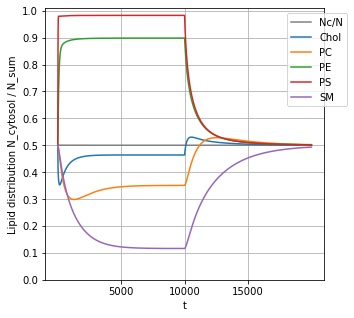

In [455]:
cyto = sol.y[:5,:]
exo = sol.y[5:,:]
distibution = cyto/(exo+cyto)
cyto_vs_n = np.sum(cyto,axis=0)/np.sum(exo+cyto, axis=0)
timepoint = len(sol.t)

ticks = np.arange(0,1.1,.1)
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(sol.t[:timepoint], cyto_vs_n, 'grey', label='Nc/N')
plt.plot(sol.t[:timepoint],distibution[:,:timepoint].T, label=lipids)

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('t')
plt.ylabel('Lipid distribution N_cytosol / N_sum')
plt.ylim(0.0,1.01)
plt.yticks(ticks)
plt.xticks([5000,10000,15000])
plt.grid()

plt.show()

In [168]:
distibution[:,-1:].T

array([[0.46380366, 0.3507662 , 0.89816887, 0.98256495, 0.11619245]])

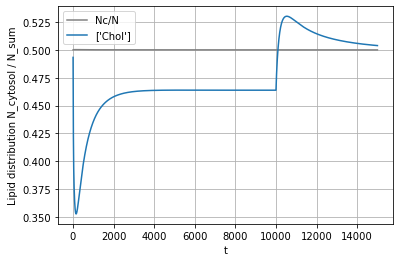

In [456]:
timepoint = len(sol.t)
index = np.where(np.logical_and(sol.t>0, sol.t<15000))

plt.plot(sol.t[index], cyto_vs_n[index], 'grey', label='Nc/N')
plt.plot(sol.t[index],np.reshape(distibution[:1,index],(1,len(index[0])),order='F').T, label=lipids[:1])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Lipid distribution N_cytosol / N_sum')
plt.grid()

plt.show()

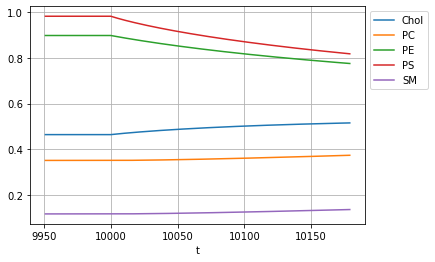

In [457]:
index = np.where(np.logical_and(sol.t>9950, sol.t<10180))
plt.plot(sol.t[index],np.reshape(distibution[:,index],(5,len(index[0])),order='F').T, label=lipids)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('t')
plt.grid()

plt.show()

Blocking of active transport leads to break down of asymmetry. Process seems to have a good pace if no or very low scramblase activity considered.

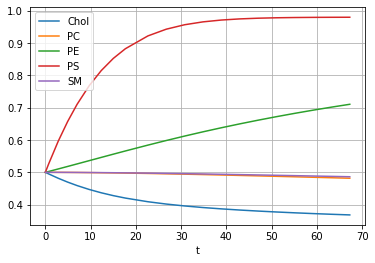

In [112]:
index = np.where(np.logical_and(sol.t>0, sol.t<70))
plt.plot(sol.t[index],np.reshape(distibution[:,index],(5,len(index[0])),order='F').T, label=lipids)
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()

plt.show()

## Figure 2

In [346]:
lambda_array = np.logspace(-3.7,-2,100)
y0 = np.append(lip_inside,lip_outside)
t = (0, 10000)
end_values = np.zeros((len(lambda_array),5))
cyto_vs_n_lam = np.zeros(len(lambda_array))
for i, lam in enumerate(lambda_array):
    sol_l = solve_ivp(dxdy, t, y0, args=([lam-1.163 * 1e-3]), method='LSODA')
    cyto = sol_l.y[:5,-1:]
    exo = sol_l.y[5:,-1:]
    cyto_vs_n_lam[i] = np.sum(cyto,axis=0)/np.sum(exo+cyto, axis=0)
    distibution = cyto/(exo+cyto)
    end_values[i]=distibution[:,:].T


/tmp/ipykernel_4149/30539345.py:48: RuntimeWarning: invalid value encountered in log
  chemical_array = R * Temp * np.log(lip_inside / lip_outside)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4469766262367D+04   r2 =                  NaN


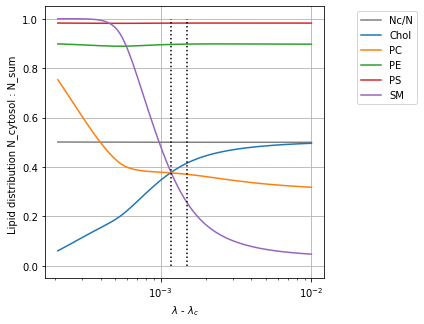

In [355]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(lambda_array, cyto_vs_n_lam, 'grey', label='Nc/N')
plt.plot(lambda_array,end_values, label=lipids)
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('$\lambda$ - $\lambda_c$')
plt.ylabel('Lipid distribution N_cytosol : N_sum ')
plt.vlines(x=[1/670, 1.163 * 1e-3], ymin=0, ymax=1,colors='black',linestyles='dotted')
plt.grid()
plt.xscale('log')
plt.show()

Problem is in newer publications, they assume(measure) a asymmetry with inside (cytosolic) levels of PS ~.98, PE~.99, debated(Chol ~.30), PC ~.20 and SM ~ .01(https://doi.org/10.1038/s41589-020-0529-6). For cholesterol and PE this asymmetry is not achievable by manipulating the coupling factor $\lambda$.   

## Figure 3 
Impact of cholesterol on compression factor $\gamma$. As cholesterol in a membrane layer further compresses other lipids.
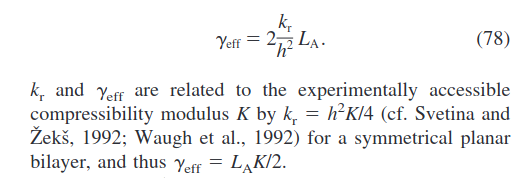
In the model expressed as:
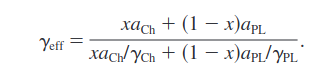

$\gamma_{eff}= L_A\cdot \frac{K}{2} \rightarrow \frac{\gamma_{PL}}{L_A}=\frac{K}{2\cdot f(x)}$ to calculate factor from modulus

Text(0, 0.5, 'f(x)')

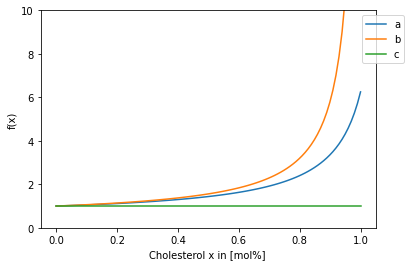

In [348]:
def compression_func(x, r_a=1.76, r_gamma=0.16):
    return ((x + r_a * (1-x))/(x*r_gamma+(1-x)*r_a))
gamma_pl=0.25
xs = np.linspace(0,1,100)
gamma_eff_a = [compression_func(x) for x in xs]
gamma_eff_b = [compression_func(x,r_gamma=0.01) for x in xs]
gamma_eff_c = [compression_func(x, r_gamma=1) for x in xs]
gamma_plot = np.array([gamma_eff_a, gamma_eff_b, gamma_eff_c])
plt.plot(xs, gamma_plot.T, label=['a','b','c'])
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.ylim(0,10)
plt.xlabel('Cholesterol x in [mol%] ')
plt.ylabel('f(x)')

## Figure 4
Changing the area value to more realistic ones. Value of $\upsilon$ not updated as there is no value in the paper, probably very important, since
$\lambda_{i,j}=\upsilon \cdot a_i \cdot a_j$

In [479]:
gamma_pl = 0.18
a_pl = 0.65
gamma_chol = 1.123
a_chol =  0.37
a_array = np.array([a_chol]+[a_pl]*4)
gamma_array = np.array([gamma_chol]+[gamma_pl]*4)
lambda_mat = 5.495296676614648e-05 * np.outer(a_array,a_array)
t_max = 20000
t = (0, t_max)
t_val = np.arange(0,t_max,1)
sol2 = solve_ivp(dxdy, t, y0, t_eval=t_val, args=(lambda_mat, 10000, gamma_array, a_array), method='LSODA')

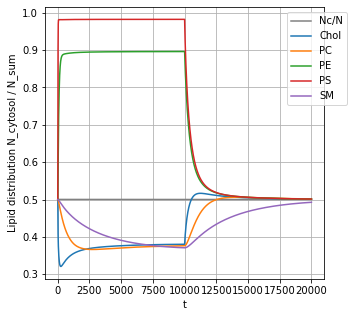

In [480]:
cyto2 = sol2.y[:5,:]
exo2 = sol2.y[5:,:]
distibution2 = cyto2/(exo2+cyto2)
cyto_vs_n2 = np.sum(cyto2,axis=0)/np.sum(exo2+cyto2, axis=0)
timepoint = len(sol2.t)

ticks = np.arange(0,1.1,.1)
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(sol2.t[:timepoint], cyto_vs_n2, 'grey', label='Nc/N')
plt.plot(sol2.t[:timepoint],distibution2[:,:timepoint].T, label=lipids)

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('t')
plt.ylabel('Lipid distribution N_cytosol / N_sum')
plt.grid()

plt.show()

In [384]:
common_vals = np.intersect1d(sol.t,sol2.t)
# Find the indices of the common values in the original arrays
x_indices = np.where(np.isin(sol.t, common_vals))[0]
y_indices = np.where(np.isin(sol2.t, common_vals))[0]


In [434]:
closest_ind = np.array([])
closest_ind = closest_ind.astype('int')
for t in sol.t:
    dist = np.abs(sol2.t-t)
    if np.min(dist) <= 1:
        closest_ind = np.append(closest_ind, np.argmin(dist))
        
len(closest_ind)-len(sol.t)

0

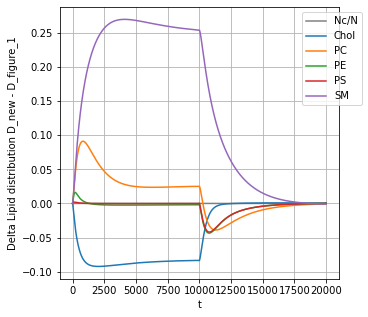

In [437]:
cyto2 = sol2.y[:5,:]
exo2 = sol2.y[5:,:]
distibution2 = cyto2/(exo2+cyto2)
cyto_vs_n2 = np.sum(cyto2,axis=0)/np.sum(exo2+cyto2, axis=0)
timepoint = len(sol2.t)

distibution_plot = distibution2[:,closest_ind]-distibution

ticks = np.arange(0,1.1,.1)
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(sol2.t[closest_ind], cyto_vs_n2[closest_ind]-cyto_vs_n, 'grey', label='Nc/N')
plt.plot(sol2.t[closest_ind],distibution_plot.T, label=lipids)

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('t')
plt.ylabel('Delta Lipid distribution D_new - D_figure_1')
plt.grid()

plt.show()

In [388]:
sol2.t[y_indices]

array([0.00000000e+00, 6.74903351e-03, 8.43629189e-03, 1.01235503e-02,
       2.00000000e+04])

## Tests to see if matrix calc is correct

In [92]:
np.diag(np.full(k,1))* kappa_N_array 

array([[3.50000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 1.24000000e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.86666667e-03, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.16666667e-04,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.60000000e-04]])

In [338]:
N_times_N_matrix

array([[0.01828358, 0.00647761, 0.00585075, 0.00287313, 0.00543284],
       [0.00647761, 0.00229493, 0.00207284, 0.00101791, 0.00192478],
       [0.00585075, 0.00207284, 0.00187224, 0.0009194 , 0.00173851],
       [0.00287313, 0.00101791, 0.0009194 , 0.00045149, 0.00085373],
       [0.00543284, 0.00192478, 0.00173851, 0.00085373, 0.00161433]])

In [94]:
np.diag(np.full(k,1))* kappa_N_array + N_times_N_matrix

array([[3.51828358e+00, 6.47761194e-03, 5.85074627e-03, 2.87313433e-03,
        5.43283582e-03],
       [6.47761194e-03, 3.53492537e-03, 2.07283582e-03, 1.01791045e-03,
        1.92477612e-03],
       [5.85074627e-03, 2.07283582e-03, 3.73890547e-03, 9.19402985e-04,
        1.73850746e-03],
       [2.87313433e-03, 1.01791045e-03, 9.19402985e-04, 1.36815920e-03,
        8.53731343e-04],
       [5.43283582e-03, 1.92477612e-03, 1.73850746e-03, 8.53731343e-04,
        1.87432836e-03]])

In [339]:
passive_mat = (np.diag(np.full(k,1))* kappa_N_array + N_times_N_matrix) * (chemical_array+mechanic_array)
passive_mat

array([[-2.15611703e+01, -3.96968837e-02, -2.21823494e-02,
         1.56573149e-02, -3.32941606e-02],
       [-3.96968837e-02, -2.16631566e-02, -7.85888949e-03,
         5.54716298e-03, -1.17956455e-02],
       [-3.58552498e-02, -1.27030028e-02, -1.41755776e-02,
         5.01034075e-03, -1.06541314e-02],
       [-1.76074888e-02, -6.23808173e-03, -3.48579776e-03,
         7.45586422e-03, -5.23193952e-03],
       [-3.32941606e-02, -1.17956455e-02, -6.59132667e-03,
         4.65245927e-03, -1.14864854e-02]])

In [340]:
passive_mat.sum(axis=0)

array([-21.6876241 ,  -0.09209677,  -0.05429394,   0.03832314,
        -0.07246236])

In [355]:
np.sum((np.ones(shape=(5,5)))* (chemical_array+mechanic_array),axis=1)

array([-16.72677429, -16.72677429, -16.72677429, -16.72677429,
       -16.72677429])